In [791]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
import dcor
import copy as cp
import csv
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
from sparta.Statistics import open_csv, window_power_spectrum, get_peaks
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [738]:
zetgem_hermes_path = Path('./00678540_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits')
zetgem_hst_path = Path('./hlsp_lowlib_hst_stis_hd052973_g230lb-g430l-g750l_v1.0_spect.fits')

In [739]:
# get the data
hdul_hermes = fits.open(zetgem_hermes_path)
s = hdul_hermes[0].data
x = hdul_hermes[0].header["CRVAL1"]
d = hdul_hermes[0].header["CDELT1"]
w = np.exp(np.arange(x, x + d * (len(s)), d)[:-1])
hdul_hermes.close()

In [740]:
hdul_hst = fits.open(zetgem_hst_path)
w_hst = hdul_hst[1].data['Wavelength']
f_hst = hdul_hst[1].data['Uncorrected']

In [746]:
plt.style.use('sparta')

In [745]:
plt.style.use('default')

In [73]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Text(0.5, 1.0, 'H$_\\alpha$')

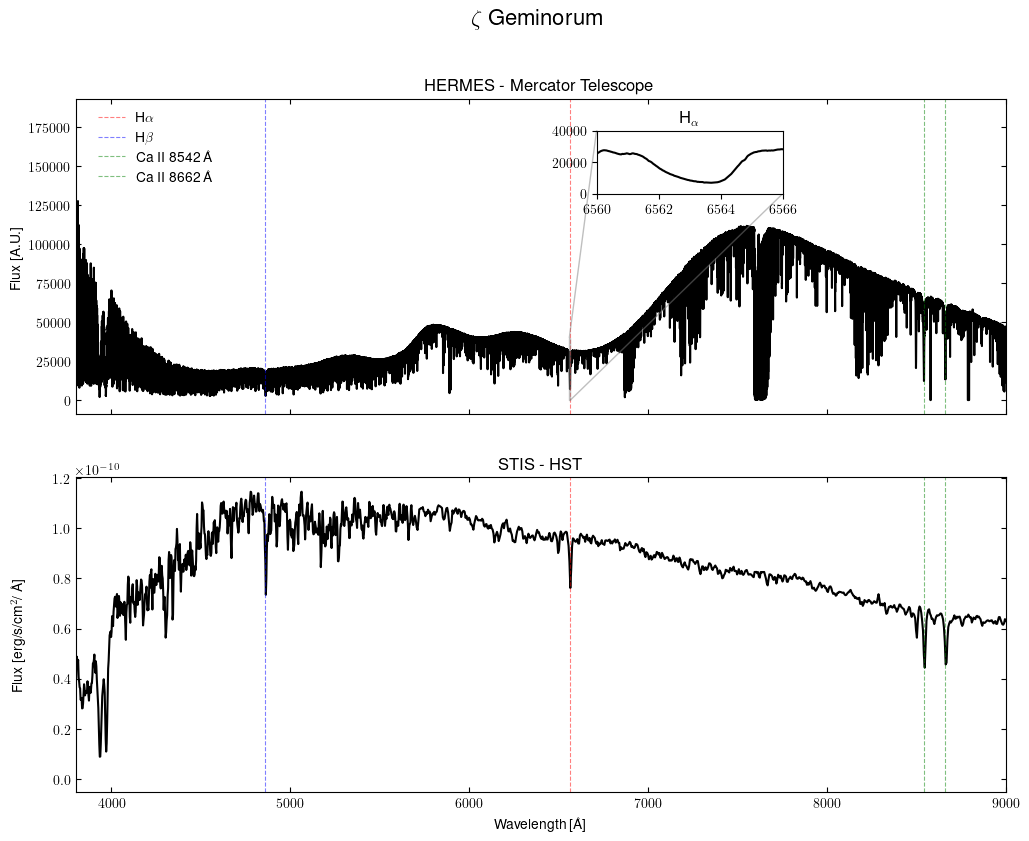

In [747]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
fig.suptitle(r'$\zeta$ Geminorum', fontsize=16, x=0.51)
#create 2 subplots
ax[0].plot(w, s, color='k')
ax[0].set_ylabel(r'Flux [A.U.]')
ax[0].set_xlim(3800, 9000)
ax[0].set_title(r'HERMES - Mercator Telescope')

ax[1].plot(w_hst, f_hst, color='k')
ax[1].set_ylabel(r'Flux [erg/s/cm$^2$/ \AA]',labelpad=20)
ax[1].set_xlabel(r'Wavelength [\AA]')
ax[1].set_xlim(3800, 9000)
ax[1].set_title(r'STIS - HST')

#put ticks on all sides
ax[0].tick_params(which='both', direction='in', top=True, right=True)
ax[1].tick_params(which='both', direction='in', top=True, right=True)

#plot halpha, hbeta, calcium at 8542 and 8662
ax[0].axvline(6563, color='r', linestyle='--', label=r'H$\alpha$',alpha=0.5,linewidth=0.8)
ax[0].axvline(4861, color='b', linestyle='--', label=r'H$\beta$',alpha=0.5,linewidth=0.8)
ax[0].axvline(8542, color='g', linestyle='--', label=r'Ca II 8542 \AA',alpha=0.5,linewidth=0.8)
ax[0].axvline(8662, color='g', linestyle='--', label=r'Ca II 8662 \AA',alpha=0.5,linewidth=0.8)
#legend location
ax[0].legend(loc='upper left', frameon=False,bbox_to_anchor=(0.01, 1))

ax[1].axvline(6563, color='r', linestyle='--', label=r'H$\alpha$',alpha=0.5,linewidth=0.8)
ax[1].axvline(4861, color='b', linestyle='--', label=r'H$\beta$',alpha=0.5,linewidth=0.8)
ax[1].axvline(8542, color='g', linestyle='--', label=r'Ca II 8542 \AA',alpha=0.5,linewidth=0.8)
ax[1].axvline(8662, color='g', linestyle='--', label=r'Ca II 8662 \AA',alpha=0.5,linewidth=0.8)

# Set limits for the inset plot
x_start, x_end, y_start, y_end = 6560, 6566, 0, 40000

# Define the position of the inset plot using numerical values
insetPosition = [0.56, 0.7, 0.2, 0.2]  # [x, y, width, height]

# Create inset axes with specified location and size
axins = ax[0].inset_axes(insetPosition)
# Plot the zoomed-in data
axins.plot(w, s)
axins.set_xlim(x_start, x_end)
axins.set_ylim(y_start, y_end)
ax[0].indicate_inset_zoom(axins)
axins.set_title(r'H$_\alpha$')

# plt.savefig('zetgem_hermes_hst.pdf')

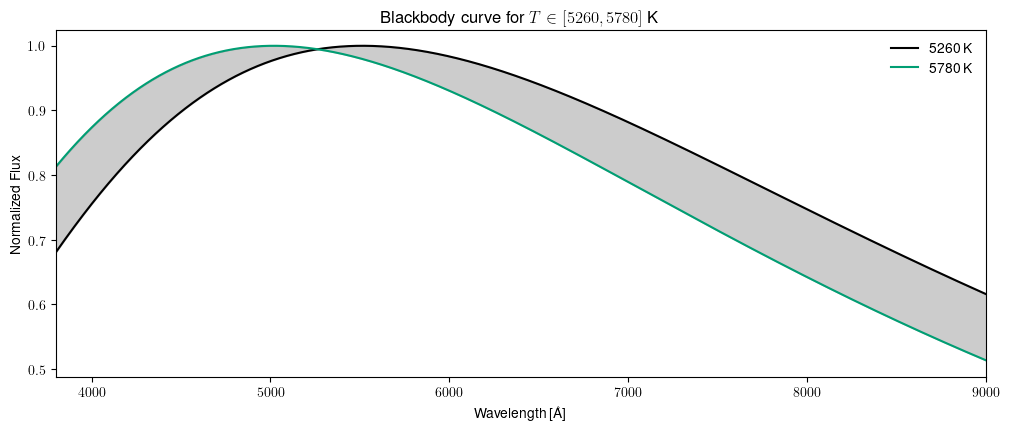

In [749]:
#plot blackbody for T between 5260-5780 K normalized to 1
plt.style.use('sparta')
T = np.linspace(5260,5780,2)
def planck(wavelength, T):
    h = 6.626e-34
    c = 3e8
    k = 1.38e-23
    return 2*h*c**2/wavelength**5 * 1/(np.exp(h*c/(wavelength*k*T))-1)

plt.figure(figsize=(12,4.5))
for i in T:
    plt.plot(w,planck(w*1e-10,i)/np.max(planck(w*1e-10,i)),label=str(int(i))+' K')
plt.fill_between(w,planck(w*1e-10,5260)/np.max(planck(w*1e-10,5260)),planck(w*1e-10,5780)/np.max(planck(w*1e-10,5780)),color='k',alpha=0.2)
plt.xlim(3800,9000)
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Normalized Flux')
plt.title(r'Blackbody curve for $T\in [5260,5780]$ K')
plt.legend(frameon=False)
plt.savefig('blackbody_zetgem.pdf')

In [149]:
delcep_rv = pd.read_csv('delcep_rv.csv')
rv = delcep_rv.rv.values
rv_err = delcep_rv.rv_err.values
times = delcep_rv.bjd.values
truth_period = 5.366267
folded_times = times % truth_period
phase = folded_times / truth_period

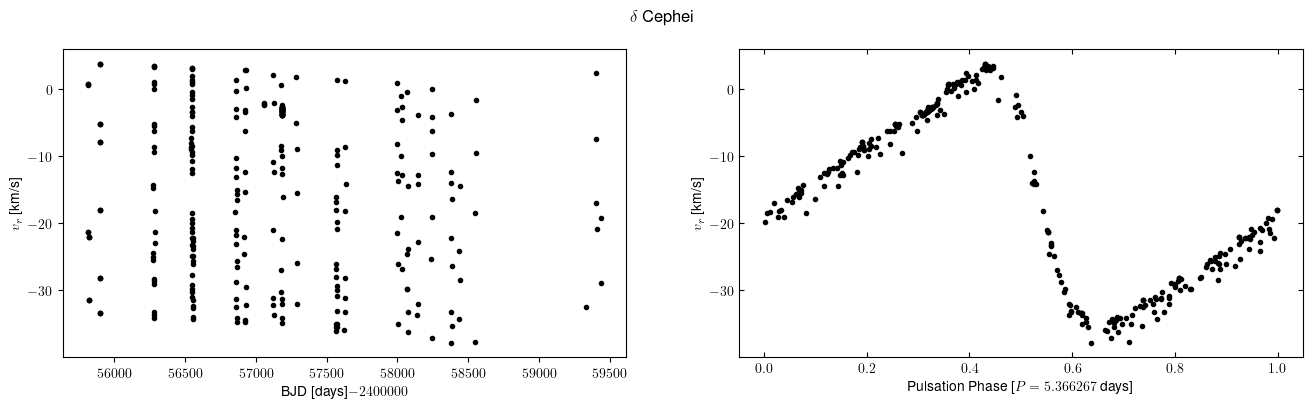

In [176]:
#print rv vs bjd and rv vs phase
fig, ax = plt.subplots(1,2,figsize=(16, 4))
fig.suptitle(r'$\delta$ Cephei')
ax[0].errorbar(times, rv, yerr=rv_err, fmt='.')
ax[0].set_xlabel(r'BJD [days]$-2400000$')
ax[0].set_ylabel(r'$v_r$ [km/s]')
ax[1].errorbar(phase, rv, yerr=rv_err, fmt='.')
ax[1].set_xlabel(r'Pulsation Phase [$P = 5.366267$ days]')
ax[1].set_ylabel(r'$v_r$ [km/s]')
#add ticks on all sides
ax[1].tick_params(which='both', direction='in', top=True, right=True)
fig.savefig('delcep_rv.pdf')

3 5 1
3 5 2
3 5 3
3 5 4
3 5 5
3 5 6
3 5 7
3 5 8
3 5 9
3 5 10
3 5 11
3 5 12
3 5 13
3 5 14
3 5 15


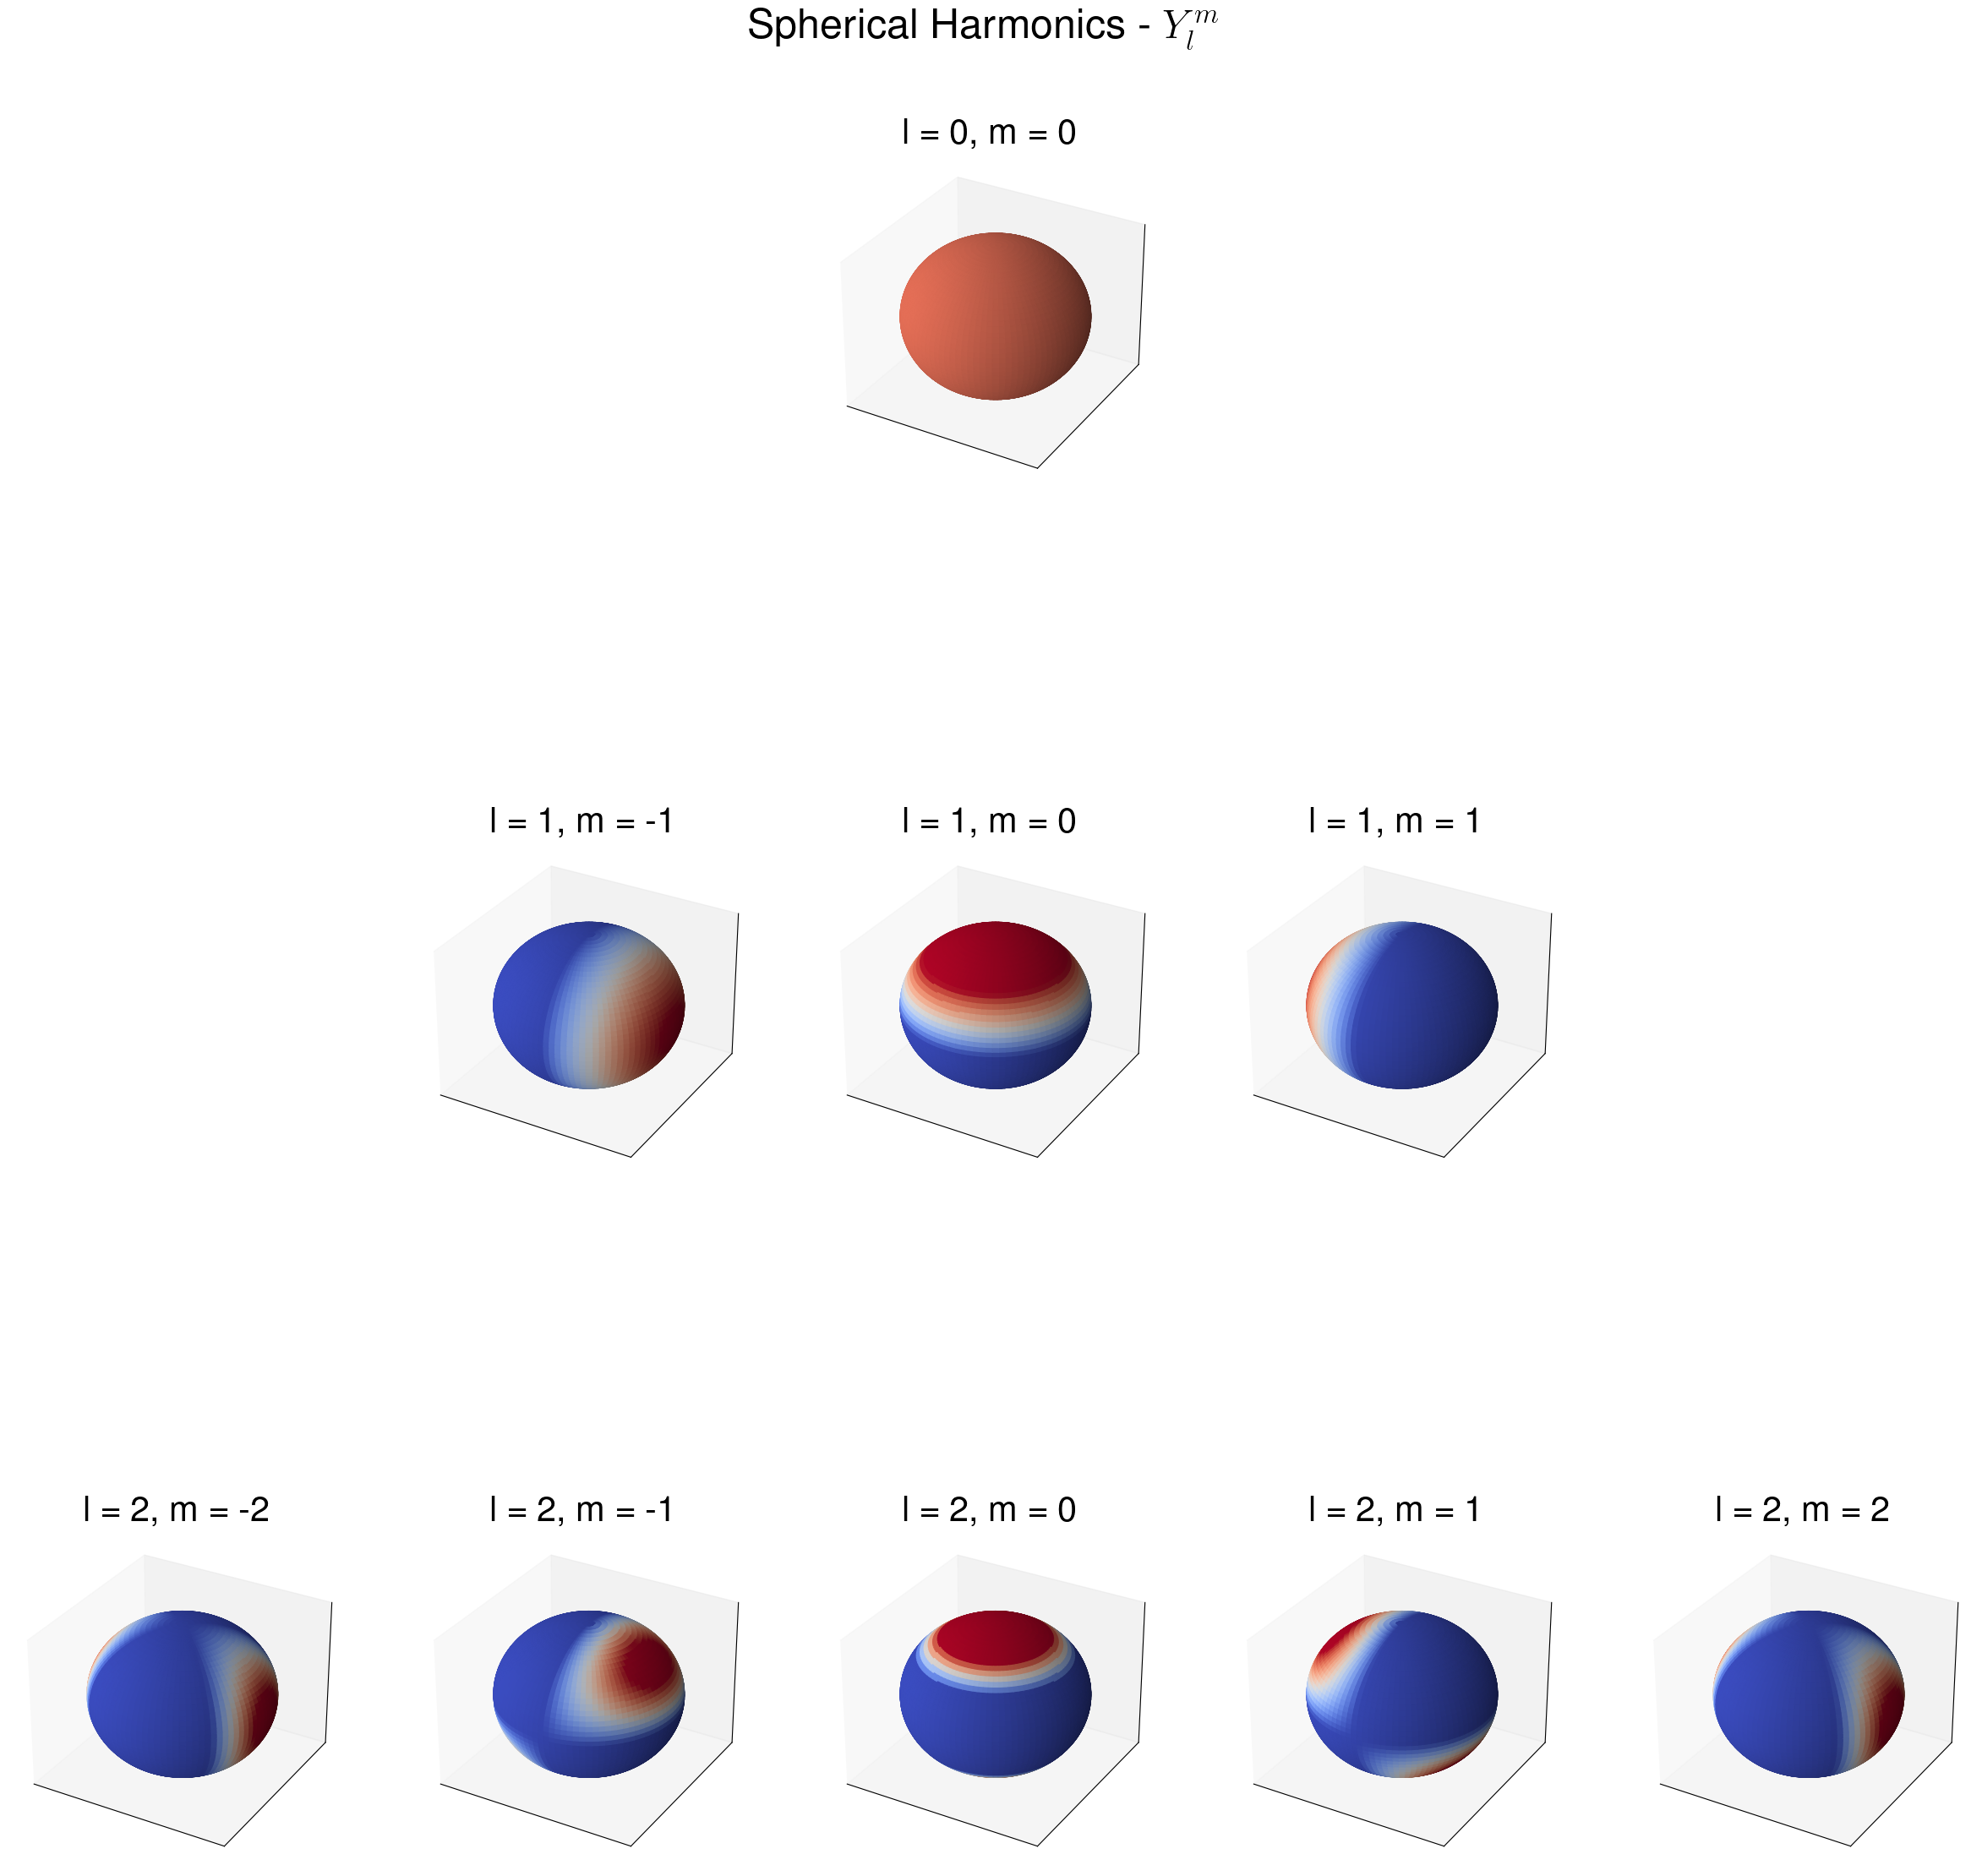

In [753]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from mpl_toolkits.mplot3d import Axes3D

def plot_spherical_harmonics():
    l_max = 2  # Maximum value of l
    ls = np.arange(0, l_max + 1)  # Array of l values
    ms = np.arange(-l_max, l_max + 1)  # Array of m values

    # Create a grid of points on the sphere
    theta, phi = np.mgrid[0:2 * np.pi:100j, 0:np.pi:50j]
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    fig = plt.figure(figsize=(30,30))
    count = 0
    for idx1, l in enumerate(ls):
        for idx2,m in enumerate(ms):
            # Make a pyramidal array of subplots with l on vertical axis and m on horizontal axis
            i= count
            subplot_num1 = l_max+1
            subplot_num2 = 2 * l_max + 1
            subplot_num3 = i+1
            print(subplot_num1,subplot_num2,subplot_num3)
            #don't add if empty
            if not(m < -l or m > l):
                ax = fig.add_subplot(subplot_num1,subplot_num2,subplot_num3,projection='3d')

                # Calculate the real part of the spherical harmonic
                Y_lm = sph_harm(m, l, theta, phi).real
                #exaggerate the amplitude
                Y_lm = Y_lm * 3

                # Plot the spherical harmonic on the sphere
                ax.plot_surface(x, y, z, facecolors=plt.cm.coolwarm(Y_lm), rstride=1, cstride=1, antialiased=True, shade=True)

                ax.set_title(f'l = {l}, m = {m}', fontsize=30)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
            count += 1
    plt.suptitle('Spherical Harmonics - $Y_l^m$', fontsize=35, y=0.89, x=0.51)
    plt.show()
    fig.savefig('spherical_harmonics.png',dpi=250)

plot_spherical_harmonics()


In [322]:
#plot from 6550 to 6570 for all three instruments: Coralie07, Coralie14, Hermes
cor07 = pd.read_pickle(Path('./spectra/zetGem_07.p'))
wave07 = cor07['wave']
flux07 = cor07['flux']/cor07['output']['continuum_linear']
cor14 = pd.read_pickle(Path('./spectra/zetGem_14.p'))
wave14 = cor14['wave']
flux14 = cor14['flux']/cor14['output']['continuum_linear']
hermes = pd.read_pickle(Path('./spectra/zetGem_hermes.p'))
wave_hermes = hermes['wave']
flux_hermes = hermes['flux']/hermes['output']['continuum_linear']

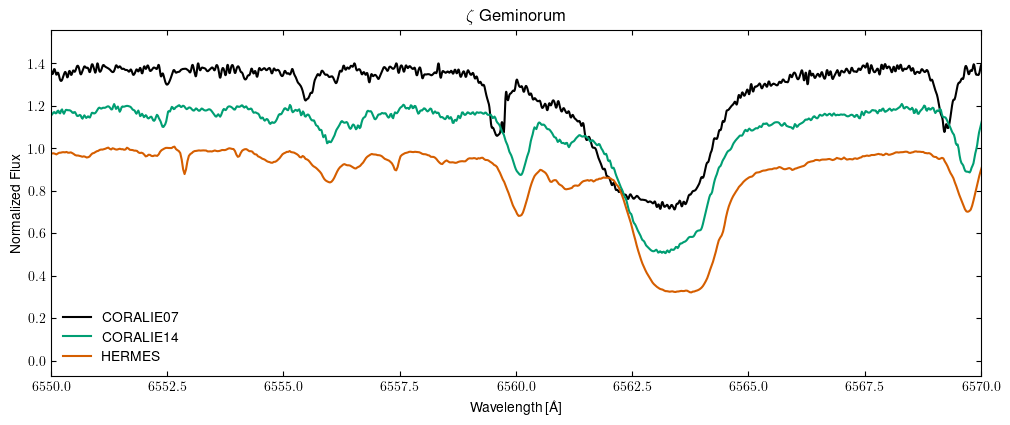

In [323]:
plt.figure(figsize=(12,4.5))
plt.plot(wave07,flux07+0.4,label='CORALIE07')
plt.plot(wave14,flux14+0.2,label='CORALIE14')
plt.plot(wave_hermes,flux_hermes,label='HERMES')
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Normalized Flux')
plt.xlim(6550,6570)
#ticks on all sides
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.title(r'$\zeta$ Geminorum')
plt.legend(frameon=False)
plt.savefig('zetgem_hermes_coralie.pdf')


In [779]:
#let's plot the different preprocessed method results on the same spectrum.

survey = "HERMES" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 3764 # minimum wavelength of the data
max_wv = 9000 # maximum wavelength of the data
obs = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,target_visits_lib=Path(r'C:\Users\kentb\Desktop\PDM\thesis\main\report_plots\spectra2'))
obs2 = cp.deepcopy(obs)

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\thesis\main\report_plots\spectra2
Selected directory: C:\Users\kentb\Desktop\PDM\thesis\main\report_plots\spectra2
File RASSINE_441860.p is not a fits file, skipping...


In [780]:
for i in obs.time_series.vals:
    I = i.TrimSpec()
    i = i.InterpolateSpectrum()
    i = i.FilterSpectrum(lowcut=5, highcut=0.15, order = 1)
    i = i.ApplyCosineBell(alpha=0.3)

In [781]:
rassine_spec = pd.read_pickle(Path('./spectra2/RASSINE_441860.p'))
wave = rassine_spec['wave']
flux = rassine_spec['flux']/rassine_spec['output']['continuum_linear']

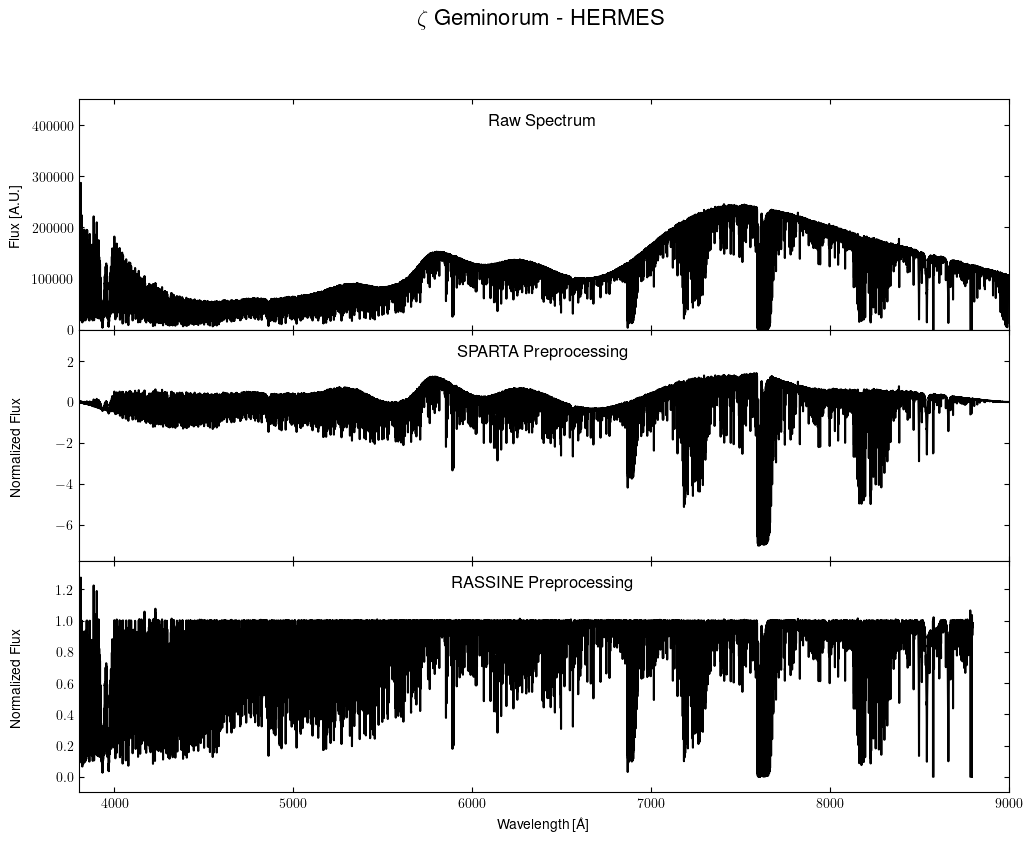

In [782]:
#plot the different preprocessed methods in 3 subplots
fig, ax = plt.subplots(3,1,figsize=(12, 9), sharex=True)
fig.suptitle(r'$\zeta$ Geminorum - HERMES', fontsize=16, x=0.51)
ax[0].plot(obs2.time_series.vals[0].wv[0],obs2.time_series.vals[0].sp[0])
ax[1].plot(obs.time_series.vals[0].wv[0],obs.time_series.vals[0].sp[0])
ax[2].plot(wave,flux)

ax[0].set_xlim(3600,9000)
ax[1].set_xlim(3600,9000)
ax[2].set_xlim(3600,9000)

ax[0].set_ylim(-1000,450000)
ax[1].set_ylim(-7.8,3.5)
ax[2].set_ylim(-0.1,1.38)

ax[0].set_ylabel(r'Flux [A.U.]')
ax[1].set_ylabel(r'Normalized Flux')
ax[2].set_ylabel(r'Normalized Flux')
ax[2].set_xlabel(r'Wavelength [\AA]')
ax[0].set_title(r'Raw Spectrum',y=0.85)
ax[1].set_title(r'SPARTA Preprocessing',y=0.85)
ax[2].set_title(r'RASSINE Preprocessing',y=0.85)
#put ticks on all sides
ax[0].tick_params(which='both', direction='in', top=True, right=True)
ax[1].tick_params(which='both', direction='in', top=True, right=True)
ax[2].tick_params(which='both', direction='in', top=True, right=True)
#move y labels a bit to the left
ax[0].yaxis.set_label_coords(-0.06,0.5)
ax[1].yaxis.set_label_coords(-0.06,0.5)
ax[2].yaxis.set_label_coords(-0.06,0.5)
plt.subplots_adjust(hspace=0)
fig.savefig('zetgem_preprocessing_hermes.pdf')


In [783]:
#same with coralie
#let's plot the different preprocessed method results on the same spectrum.

survey = "CORALIE" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 3866 # minimum wavelength of the data
max_wv = 6896 # maximum wavelength of the data
obs = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,target_visits_lib=Path(r'C:\Users\kentb\Desktop\PDM\thesis\main\report_plots\spectra3'))
obs2 = cp.deepcopy(obs)

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\thesis\main\report_plots\spectra3
Selected directory: C:\Users\kentb\Desktop\PDM\thesis\main\report_plots\spectra3
File RASSINE_CORALIE.2015-01-24T02_26_56.000.p is not a fits file, skipping...


In [784]:
for i in obs.time_series.vals:
    I = i.TrimSpec()
    i = i.InterpolateSpectrum()
    i = i.FilterSpectrum(lowcut=3, highcut=0.15, order = 1)
    i = i.ApplyCosineBell(alpha=0.3)

In [785]:
rassine_spec = pd.read_pickle(Path('./spectra3/RASSINE_CORALIE.2015-01-24T02_26_56.000.p'))
wave = rassine_spec['wave']
flux = rassine_spec['flux']/rassine_spec['output']['continuum_linear']

In [793]:
#plot the different preprocessed methods in 3 subplots
fig, ax = plt.subplots(3,1,figsize=(12, 9), sharex=True)
fig.suptitle(r'$\zeta$ Geminorum - CORALIE', fontsize=16, x=0.51)
ax[0].plot(obs2.time_series.vals[0].wv[0],obs2.time_series.vals[0].sp[0])
ax[1].plot(obs.time_series.vals[0].wv[0],obs.time_series.vals[0].sp[0])
ax[2].plot(wave,flux)

ax[0].set_xlim(3800,6950)


ax[0].set_ylim(-1e9,2.8e10)
ax[1].set_ylim(-7.8,4)
ax[2].set_ylim(-0.1,1.4)

ax[0].set_ylabel(r'Flux [A.U.]')
ax[1].set_ylabel(r'Normalized Flux')
ax[2].set_ylabel(r'Normalized Flux')
ax[2].set_xlabel(r'Wavelength [\AA]')
ax[0].set_title(r'Raw Spectrum',y=0.85)
ax[1].set_title(r'SPARTA Preprocessing',y=0.85)
ax[2].set_title(r'RASSINE Preprocessing',y=0.85)
#put ticks on all sides
ax[0].tick_params(which='both', direction='in', top=True, right=True)
ax[1].tick_params(which='both', direction='in', top=True, right=True)
ax[2].tick_params(which='both', direction='in', top=True, right=True)
#move y labels a bit to the left
ax[0].yaxis.set_label_coords(-0.06,0.5)
ax[1].yaxis.set_label_coords(-0.06,0.5)
ax[2].yaxis.set_label_coords(-0.06,0.5)
plt.subplots_adjust(hspace=0)
fig.savefig('zetgem_preprocessing_coralie14.pdf')

<IPython.core.display.Javascript object>

# 3.4 -  Asserting a peak's statistical significance

In [378]:
# DATA PARAMETERS

survey = "HERMES" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 3800 # minimum wavelength of the data
max_wv = 8800 # maximum wavelength of the data
spec_dir = r"C:\Users\kentb\Desktop\PDM\data\Hermes\zetGem_Hermes_spectra" # directory of the spectrum
obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir)

rv_dir =  r"C:\Users\kentb\Desktop\PDM\data\RV\zetGem_rv.csv"  # directory of the RVs
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
unique_id = True
if survey == "CORALIE":
    try:
        ids = df.unique_id.astype(str).values
    except AttributeError:
        print("No unique_id column in the RV file, using bjd instead")
        unique_id = False
        ids = None
        times = times - int(min(times))
        print(times)
        print(obs_data.time_series.times)
elif survey == "HERMES":
    ids = df.unique_id.astype(int).values
print(len(rv))
print(len(obs_data.time_series.times))
obs_data.rearrange_time_series(rv=rv, times=times,ids=ids,unique_id=unique_id)
print(len(obs_data.time_series.times))

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\data\Hermes\zetGem_Hermes_spectra
Selected directory: C:\Users\kentb\Desktop\PDM\data\Hermes\zetGem_Hermes_spectra
46
47
Matching ratio -> 100 %
46


In [382]:
def change_to_rassine(obs, directory):
    """
    Change the spectrum of the observations to the RASSINE spectrum.
    :param obs: Observations object
    :param directory: directory of the RASSINE spectrum
    :return: Observations object with RASSINE spectrum
    """
    for idx, file in enumerate(os.listdir(directory)):
        if survey=='HERMES':
            file_path = os.path.join(dir, file)
            unique_id=file.split('.')[0]
            unique_id=unique_id.split('_')[-1]
        rassine_spec = pd.read_pickle(file_path)
        wave = rassine_spec['wave']
        flux = rassine_spec['flux'] / rassine_spec['output']['continuum_linear']
        for idx2,_ in enumerate(obs.time_series.vals):
            if str(obs.time_series.unique_ids[idx2])==unique_id:
                print('found')
                obs.time_series.vals[idx2].wv[0] = wave
                obs.time_series.vals[idx2].sp[0] = flux
    return obs

In [380]:
rassine_dir = Path(r'C:\Users\kentb\Desktop\PDM\data\Rassine_spectra\hermes\zetGemHermes_output')

In [385]:
#replace in obs_data.time_series.vals the flux by the flux/continuum

for idx, file in enumerate(os.listdir(rassine_dir)):
    file_path = os.path.join(rassine_dir, file)
    unique_id=file.split('.')[0]
    unique_id=unique_id.split('_')[-1]
    rassine_spec = pd.read_pickle(file_path)
    wave = rassine_spec['wave']
    flux = rassine_spec['flux']/rassine_spec['output']['continuum_linear']
    for idx2,_ in enumerate(obs_data.time_series.vals):
        if str(obs_data.unique_ids[idx2]) == unique_id:
            print(obs_data.unique_ids[idx2],unique_id," ok")
            obs_data.time_series.vals[idx2].wv[0] = wave
            obs_data.time_series.vals[idx2].sp[0] = flux

441860 441860  ok
443546 443546  ok
454450 454450  ok
454919 454919  ok
455198 455198  ok
455659 455659  ok
455898 455898  ok
587638 587638  ok
588320 588320  ok
588865 588865  ok
589960 589960  ok
590977 590977  ok
592019 592019  ok
592666 592666  ok
593549 593549  ok
594552 594552  ok
595705 595705  ok
620699 620699  ok
621006 621006  ok
621706 621706  ok
622030 622030  ok
622272 622272  ok
622621 622621  ok
622887 622887  ok
632988 632988  ok
633506 633506  ok
633742 633742  ok
634009 634009  ok
634294 634294  ok
634640 634640  ok
634889 634889  ok
635151 635151  ok
635370 635370  ok
666624 666624  ok
667363 667363  ok
668372 668372  ok
668680 668680  ok
677082 677082  ok
677874 677874  ok
678540 678540  ok
679492 679492  ok
680337 680337  ok
680877 680877  ok
848683 848683  ok
857649 857649  ok
864615 864615  ok


In [413]:
# PERIODOGRAM PARAMETERS

baseline = np.max(obs_data.time_series.times) - np.min(obs_data.time_series.times) # baseline of the data
min_freq = 2/baseline # Or maybe 1/2/baseline to be sure but let's test it that way.
max_freq = 2.5 # depends on the star.
freq_range = (min_freq, max_freq) # frequency range of the periodograms
points_per_peak = 5
periodogram_grid_resolution = points_per_peak*max_freq*baseline # frequency resolution of the periodograms
print('Baseline: ',baseline)
print('Grid resolution: ',periodogram_grid_resolution)

# RESULS DIRECTORY

results_dir = Path(r'C:\Users\kentb\Desktop\PDM\thesis\main\report_plots') # directory of the results

Baseline:  2167.0952993999963
Grid resolution:  27088.691242499954


In [414]:
## Compute periodograms

# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,periodogram_grid_resolution=periodogram_grid_resolution)

obs_data.periodicity_detector.calc_GLS()

print("GLS done",flush=True)

# obs_data.periodicity_detector.calc_PDC(calc_biased_flag=False, calc_unbiased_flag=True)

# print("PDC done",flush=True)

# obs_data.periodicity_detector.calc_USURPER(calc_biased_flag=False, calc_unbiased_flag=True)

# print("USURPER done",flush=True)

# obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

# print("Shape done",flush=True)

# obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

# print("Shift done",flush=True)

GLS done


In [415]:
# Save the observations instance in a csv file with the name of the spec_dir name in the results directory
star = 'ZetGem'
with open(os.path.join(results_dir, f"{star}_{survey}_{str(min_wv)}_{str(max_wv)}.csv"), 'w',newline='',encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["freq", "gls","usurper","pdc_unbiased","shape_periodogram", "shift_periodogram"])
    for i in range(len(obs_data.periodicity_detector.results_frequency['GLS'])):
        writer.writerow([obs_data.periodicity_detector.results_frequency['GLS'][i],
                        obs_data.periodicity_detector.results_power['GLS'][i],
                        0,
                        0,
                        0,
                        0])

In [466]:
periodogram_path = Path(r'C:\Users\kentb\Desktop\PDM\thesis\main\report_plots\ZetGem_HERMES_3800_8800.csv')
results = open_csv(periodogram_path)
window_freq, window_power = window_power_spectrum(obs_data.time_series.times, min_freq = 2/baseline, max_freq = 2.5)

In [467]:
t = obs_data.time_series.times
y = obs_data.time_series.calculated_vrad_list
#do lomb scargle
ls = LombScargle(t, y)
freq, power = ls.autopower(minimum_frequency=2/baseline, maximum_frequency=2.5, samples_per_peak=5)
#compute fap with bootstrap
p = [0.1,0.01,0.001]
fal = ls.false_alarm_level(p)
    

In [468]:
from scipy.signal import find_peaks

In [667]:
#function that finds the peaks and their harmonics+aliases
def peak_finder(power,threshold=0.2,distance=200):
    peaks = find_peaks(power, height=threshold,distance=distance)
    return peaks

In [668]:
def find_failure_modes(peaks,n_max = 3,m_max = 3):
    m_max = np.arange(0,m_max+1)
    n_max = np.arange(0,n_max+1)
    periods = peaks[:,0]
    powers = peaks[:,1]
    window_periods = [1,1/365]
    #find the harmonics
    avoid_list = []
    avoid_list_powers = []
    true_periods = []
    true_periods_powers = []
    for (idx, period), (_,power) in zip(enumerate(periods),enumerate(powers)):
        for window_period in window_periods:
            for n in n_max:
                for m in m_max:
                    if n==0 and m==0:
                        continue
                    else:
                        spurious_period_pos = np.abs(m/period + n/window_period)**(-1)
                        spurious_period_neg = np.abs(m/period - n/window_period)**(-1)
                    #check if spurious periods are close to any of the peaks after the one we are looking at
                    #if so, print the peak and the spurious period and remove the alias from the iteration
                    for period2,power2 in zip(periods[idx+1:],powers[idx+1:]):
                        if np.abs(spurious_period_pos-period2)/period2<0.05 and period2 not in avoid_list:
                            n2 = np.abs(n)
                            avoid_list.append(period2)
                            avoid_list_powers.append(power2)
                            true_periods.append(period)
                            true_periods_powers.append(power)
                            print('Spurious period found at',spurious_period_pos,'which is close to',period2)
                            print('Peak at',period,'with power',power)
                            print('n =',n2,'m =',m)
                            print('Window period =',window_period)
                            print('------------------------------------------')
                        if np.abs(spurious_period_neg-period2)/period2<0.05 and period2 not in avoid_list:
                            avoid_list.append(period2)
                            avoid_list_powers.append(power2)
                            true_periods.append(period)
                            true_periods_powers.append(power)
                            n2 = -np.abs(n)
                            print('Spurious period found at',spurious_period_neg,'which is close to',period2)
                            print('Peak at',period,'with power',power)
                            print('n =',n2,'m =',m)
                            print('Window period =',window_period)
                            print('------------------------------------------')
    return np.unique(true_periods),np.unique(true_periods_powers), np.unique(avoid_list),np.unique(avoid_list_powers)


In [688]:
#get peaks
peaks = peak_finder(results['gls'],threshold=fal[2],distance = 100)
peaks = peaks[0]
peaks_periods = results['period'][peaks]
peaks_powers = results['gls'][peaks]
peaks = np.array([peaks_periods,peaks_powers]).T
#sort by power
peaks = peaks[peaks[:,1].argsort()[::-1]]
#keep only the first 10 peaks
# peaks = peaks[:10]
print(peaks)

[[10.14937851  0.93354518]
 [ 1.10584141  0.68536678]
 [ 0.90807185  0.68194245]
 [ 1.08333098  0.63423491]
 [12.71172747  0.62683332]
 [ 0.48046632  0.6243932 ]
 [ 0.89629392  0.56728629]
 [ 1.08846752  0.56137489]
 [11.90188543  0.53652388]
 [ 0.92474964  0.52940166]
 [ 0.47105033  0.5269792 ]
 [ 0.51538606  0.52156239]
 [ 8.84962144  0.51324488]
 [ 0.51675266  0.50623844]
 [ 0.4755155   0.50594355]
 [ 0.89280812  0.50093743]
 [ 7.53091222  0.49626326]
 [ 0.52862172  0.48975445]
 [ 0.47226575  0.48363916]
 [ 8.45200975  0.48342363]
 [ 0.53068256  0.47761429]
 [ 0.47714879  0.47430992]
 [ 1.06656789  0.47169116]
 [ 0.51923886  0.46280537]
 [ 0.52516801  0.45960922]]


In [693]:
true_periods,true_powers, spurious_periods,spurious_powers = find_failure_modes(peaks,n_max=10,m_max=10)
print(true_periods)
print(spurious_periods)

Spurious period found at 1.1277087233046055 which is close to 1.1058414125775609
Peak at 10.14937850974145 with power 0.933545175897781
n = 0 m = 9
Window period = 1
------------------------------------------
Spurious period found at 1.1277087233046055 which is close to 1.0833309835032967
Peak at 10.14937850974145 with power 0.933545175897781
n = 0 m = 9
Window period = 1
------------------------------------------
Spurious period found at 1.1277087233046055 which is close to 1.0884675229035214
Peak at 10.14937850974145 with power 0.933545175897781
n = 0 m = 9
Window period = 1
------------------------------------------
Spurious period found at 1.014937850974145 which is close to 1.0665678889085728
Peak at 10.14937850974145 with power 0.933545175897781
n = 0 m = 10
Window period = 1
------------------------------------------
Spurious period found at 0.9103089020498963 which is close to 0.9080718461499759
Peak at 10.14937850974145 with power 0.933545175897781
n = 1 m = 1
Window period = 

In [694]:
#check if there are same elements in true_periods and spurious_periods
print(true_periods)
print(spurious_periods)
for i in true_periods:
    if i in spurious_periods:
        print('same element in true and spurious periods')
        print(i)
        #delete the element from true_periods
        true_periods = true_periods[true_periods!=i]
print(true_periods)
print(spurious_periods)

#same for powers
print(true_powers)
print(spurious_powers)
for i in true_powers:
    if i in spurious_powers:
        print('same element in true and spurious powers')
        print(i)
        #delete the element from true_periods
        true_powers = true_powers[true_powers!=i]
print(true_powers)
print(spurious_powers)

[ 0.48046632  1.08333098  1.10584141 10.14937851]
[ 0.47105033  0.47226575  0.4755155   0.47714879  0.48046632  0.51538606
  0.51675266  0.51923886  0.52516801  0.52862172  0.53068256  0.89280812
  0.89629392  0.90807185  0.92474964  1.06656789  1.08333098  1.08846752
  1.10584141  7.53091222  8.45200975  8.84962144 11.90188543 12.71172747]
same element in true and spurious periods
0.4804663221443763
same element in true and spurious periods
1.0833309835032967
same element in true and spurious periods
1.1058414125775609
[10.14937851]
[ 0.47105033  0.47226575  0.4755155   0.47714879  0.48046632  0.51538606
  0.51675266  0.51923886  0.52516801  0.52862172  0.53068256  0.89280812
  0.89629392  0.90807185  0.92474964  1.06656789  1.08333098  1.08846752
  1.10584141  7.53091222  8.45200975  8.84962144 11.90188543 12.71172747]
[0.6243932  0.63423491 0.68536678 0.93354518]
[0.45960922 0.46280537 0.47169116 0.47430992 0.47761429 0.48342363
 0.48363916 0.48975445 0.49626326 0.50093743 0.5059435

In [695]:
#find powers of true periods and spurious periods in the results
true_periods_idx = []
spurious_periods_idx = []
for period in true_periods:
    true_periods_idx.append(np.where(results['period']==period)[0][0])
for period in spurious_periods:
    spurious_periods_idx.append(np.where(results['period']==period)[0][0])
true_periods_powers = results['gls'][true_periods_idx]
spurious_periods_powers = results['gls'][spurious_periods_idx]

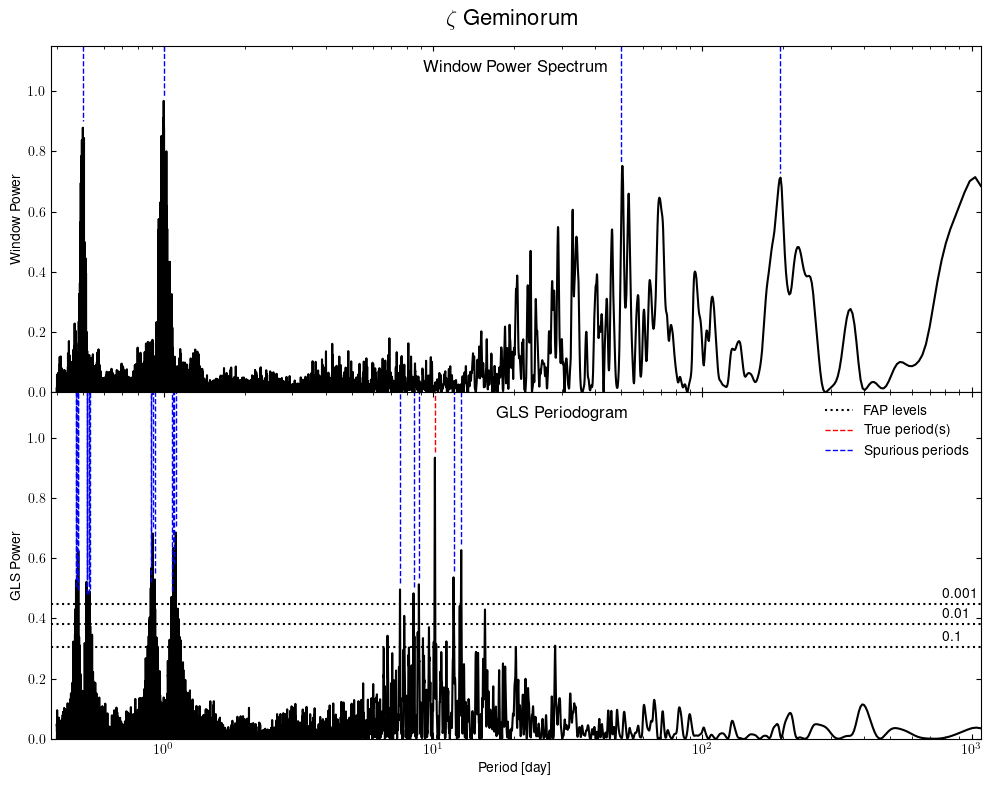

In [735]:
#plot window power and gls in two subplots
fig, ax = plt.subplots(2,1,figsize=(12, 9), sharex=True)
fig.suptitle(r'$\zeta$ Geminorum', fontsize=16, x=0.51, y=0.92)
ax[0].plot(1/window_freq,window_power)
ax[0].set_ylabel(r'Window Power')
ax[1].plot(results['period'],results['gls'])
ax[1].set_ylabel(r'GLS Power')
ax[1].set_xlabel(r'Period [day]')
#set ylim to 1.15
ax[0].set_ylim(0,1.15)
ax[1].set_ylim(0,1.15)
ax[0].set_xlim(0.38,1/(2/baseline))
ax[1].set_xlim(0.38,1/(2/baseline))
# ax[0].set_title(r'Window Power Spectrum')
#put title inside the plot
ax[0].set_title(r'Window Power Spectrum',y=0.98,pad=-14)
ax[1].set_title(r'GLS Periodogram',x= 0.55,y=0.98,pad=-14)
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
#put in semilog x
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#put ticks on all sides
ax[0].tick_params(which='both', direction='in', top=True, right=True)
ax[1].tick_params(which='both', direction='in', top=True, right=True)
#put plots closer together
plt.subplots_adjust(hspace=0)
#plot fap levels and annotate above the line
ax[1].axhline(fal[0],color='k',linestyle=':',label='FAP levels')
ax[1].annotate('0.1',xy=(0.78e3,fal[0]+0.02))
ax[1].axhline(fal[1],color='k',linestyle=':')
ax[1].annotate('0.01',xy=(0.78e3,fal[1]+0.02))
ax[1].axhline(fal[2],color='k',linestyle=':')
ax[1].annotate('0.001',xy=(0.78e3,fal[2]+0.02))
#plot vertical lines at true periods going from top to 0.02 above the power
ax[1].vlines(true_periods,true_periods_powers+0.02,1.15,linestyle='--',label='True period(s)',color='r',lw=1)
#same for spurious periods
ax[1].vlines(spurious_periods,spurious_periods_powers+0.02,1.15,linestyle='--',label='Spurious periods',color='b',lw=1)
#plot on window power the 1 day and 1 year periods and one at forty days
ax[0].vlines(0.5,1.15,0.9,linestyle='--',color='b',lw=1)
ax[0].vlines(1,1.15,0.98,linestyle='--',color='b',lw=1)
ax[0].vlines(194,1.15,0.73,linestyle='--',color='b',lw=1)
ax[0].vlines(50,1.15,0.76,linestyle='--',color='b',lw=1)
ax[1].legend(frameon=False)
fig.savefig('windows_examples.pdf')

In [835]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Function to generate a synthetic spectrum with a telluric line and pulsating star absorption peak
def generate_spectrum(wavelengths, pulsation_phase):
    # telluric_line1 = -np.exp(-((wavelengths - 5896) / 1) ** 2)  # Gaussian telluric line
    telluric_line2 = -np.exp(-((wavelengths - 5890) / 0.5) ** 2)  # Gaussian telluric line
    star_peak = -np.exp(-((wavelengths - 5890 + 1.5 * np.sin(pulsation_phase)) / 1) ** 2)  # Pulsating star absorption peak
    return 0.8 + 0.2 * (telluric_line2 + star_peak)

# # Initialize plot
# fig, ax = plt.subplots()
# wavelengths = np.linspace(5880, 5910, 50)
# line, = ax.plot(wavelengths, generate_spectrum(wavelengths, 0.0), lw=2)

# Animation function
def update(frame):
    line.set_ydata(generate_spectrum(wavelengths, frame))
    # ax.axvline(x=5896, color='r', linestyle='--', label='Telluric Line 1')
    ax.axvline(x=5890, color='r', linestyle='--', label='Telluric Line 2')
    ax.set_xlabel(r'Wavelength $\AA$')
    ax.set_ylabel('Intensity')
    ax.set_title('Blending of Telluric Line and Pulsating Star Absorption Peak')
    return line,

# # Set animation properties
# ani = FuncAnimation(fig, update, frames=np.linspace(0, 2 * np.pi, 100),
#                     interval=50, blit=True)

# # Enable interactive mode for the notebook
# %matplotlib notebook

# # Show the plot
# plt.figure(1)
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Intensity')
# #horizontal line on telluric lines
# plt.axvline(x=5896, color='b', linestyle='--', label='Pulsating Star Absorption Peak')
# plt.axvline(x=6563, color='r', linestyle='--', label='Telluric Line 1')
# plt.axvline(x=6563+10, color='r', linestyle='--', label='Telluric Line 2')
# plt.title('Blending of Telluric Line and Pulsating Star Absorption Peak')

# # Display the animation
# HTML(ani.to_jshtml())

# # ani.save('animation.gif', writer='pillow', fps=30)

In [ ]:
%matplotlib inline

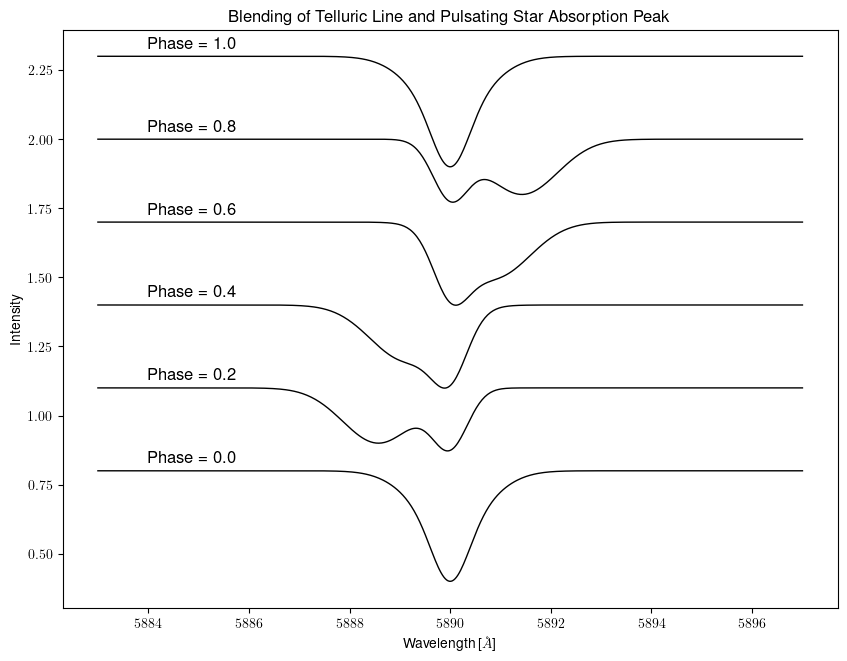

In [843]:
wavelengths = np.linspace(5883, 5897, 500)
phases = np.linspace(0, 2 * np.pi, 6)
y_decalage = 0
plt.figure(figsize=(10,7.5))
for phase in phases:
    plt.plot(wavelengths, generate_spectrum(wavelengths, phase) +y_decalage, lw=1, color = 'k')
    plt.annotate('Phase = ' + str(round(phase/2/np.pi, 2)), xy=(5884, 0.83 + y_decalage), fontsize=12)
    y_decalage += 0.3
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Intensity')
plt.title('Blending of Telluric Line and Pulsating Star Absorption Peak')
plt.savefig('telluric_line_pulsating_star.pdf')

In [ ]:
# DATA PARAMETERS

survey = "HERMES" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 3800 # minimum wavelength of the data
max_wv = 9000 # maximum wavelength of the data
spec_dir = r"C:\Users\kentb\Desktop\PDM\data\Hermes\delCep_Hermes_spectra" # directory of the spectrum
obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir)
obs_data2 = cp.deepcopy(obs_data)
period_truth = 0.566777

In [ ]:
#replace in obs_data.time_series.vals the flux by the flux/continuum
delCep_path = Path(r'C:\Users\kentb\Desktop\PDM\data\Rassine_spectra\hermes\delCep_output')
for idx, file in enumerate(os.listdir(delCep_path)):
    file_path = os.path.join(delCep_path, file)
    unique_id=file.split('.')[0]
    unique_id=unique_id.split('_')[-1]
    rassine_spec = pd.read_pickle(file_path)
    flux = rassine_spec['flux']/rassine_spec['output']['continuum_linear']
    for idx2,_ in enumerate(obs_data.time_series.vals):
        if str(obs_data.unique_ids[idx2]) == unique_id:
            print(obs_data.unique_ids[idx2],unique_id," ok")
            obs_data.time_series.vals[idx2].sp[0] = flux

In [ ]:
#fold the times and get the new order of the indices

times_folded = [t%period_truth for t in obs_data.time_series.times]
print(obs_data.time_series.times)
print(times_folded)
print(obs_data.time_series.vals)

indices = np.argsort(times_folded).tolist()
obs_data.time_series.times = [obs_data.time_series.times[i] for i in indices]
obs_data.time_series.vals = [obs_data.time_series.vals[i] for i in indices]
print([t%period_truth for t in obs_data.time_series.times])
print(obs_data.time_series.vals)
print(len(obs_data.time_series.vals), len(obs_data.time_series.times),len(times_folded))

In [ ]:
#get phases


# 4.1 Tellurics

In [848]:
# Load data for all stars by looping through the directory
delCep_results = []
RRLyr_results = []
RCru_results = []
BGCru_results = []
for filename in os.listdir('./tellurics/delCep'):
    delCep_results.append(open_csv('./tellurics/delCep/'+filename))
    print(filename)
for filename in os.listdir('./tellurics/RRLyr'):
    RRLyr_results.append(open_csv('./tellurics/RRLyr/'+filename))
    print(filename)
for filename in os.listdir('./tellurics/RCru'):
    RCru_results.append(open_csv('./tellurics/RCru/'+filename))
    print(filename)
for filename in os.listdir('./tellurics/BGCru'):
    BGCru_results.append(open_csv('./tellurics/BGCru/'+filename))
    print(filename)

delCep_Hermes_spectra_4000_4200.csv
delCep_Hermes_spectra_4200_4400.csv
delCep_Hermes_spectra_4400_4600.csv
delCep_Hermes_spectra_4859_4862.csv
delCep_Hermes_spectra_5888_5892.csv
delCep_Hermes_spectra_5893_5897.csv
delCep_Hermes_spectra_6260_6300.csv
delCep_Hermes_spectra_6561_6564.csv
delCep_Hermes_spectra_6800_7000.csv
delCep_Hermes_spectra_7420_7520.csv
delCep_Hermes_spectra_7500_7700.csv
delCep_Hermes_spectra_7600_7630.csv
RRLyr_Hermes_spectra_4000_4200.csv
RRLyr_Hermes_spectra_4200_4400.csv
RRLyr_Hermes_spectra_4400_4600.csv
RRLyr_Hermes_spectra_4859_4862.csv
RRLyr_Hermes_spectra_5888_5892.csv
RRLyr_Hermes_spectra_5893_5897.csv
RRLyr_Hermes_spectra_6260_6300.csv
RRLyr_Hermes_spectra_6561_6564.csv
RRLyr_Hermes_spectra_6800_7000.csv
RRLyr_Hermes_spectra_7420_7520.csv
RRLyr_Hermes_spectra_7500_7700.csv
RRLyr_Hermes_spectra_7600_7630.csv
RCru_4000_4200.csv
RCru_4200_4400.csv
RCru_4400_4600.csv
RCru_4859_4862.csv
RCru_5888_5892.csv
RCru_5893_5897.csv
RCru_6260_6300.csv
RCru_6561_6564.